# Decomposition-Residuals Neural Networks: Hybrid system identification applied to electricity forecasting

### Konstantinos Theodorakos
##### Ph.D. student
#### KU Leuven, Belgium
konstantinos.theodorakos@esat.kuleuven.be
##### Dept. of Electrical Engineering (ESAT) – Research Group STADIUS, Center for Dynamical Systems, Signal Processing, and Data Analytics

Code adapted from: https://www.tensorflow.org/tutorials/structured_data/time_series

## Imports:

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from layers.DataframeDecompositionLayer import DataframeDecompositionLayer

## Settings:

In [2]:
do_DecompositionResiduals = True # DR-DNN or plain DNN
cpu_only = False # CPU or GPU acceleration
do_extras = False # Extras: 3 STD outliers, Day/year sines,
MAX_EPOCHS = 150 # 300 # 500 # 350 # 150 # 20
stop_early_patience = 8
reduce_learning_rate_patience = 5
min_learning_rate_on_plateau= 1e-4
window_stride = 1 # 12 # 24 # 1 # hours
use_stl = True # False for ablation study
use_moving_filters = True # False for ablation study
use_extra_filters = True # False for default DR-DNN

ablation_text = ""
if use_stl == False or use_moving_filters == False:
    use_ablation = True
    if use_stl:
        ablation_text = "_no_moving_filters"
    else:
        ablation_text = "_no_STL"
else:
    use_ablation = False


## Parameters:

In [3]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
seed = 0

## Data:

In [4]:
df = pd.read_excel("data/ActualsAll_8PM.xlsx") # Read from excel

df.index = pd.to_datetime(df.pop('Time'))

# df = df.head(int(365 * 24 * 2.5)).copy() # Pre-COVID: first 2.5 years
# df = df.tail(int(365 * 24 * 2)).copy() # Post-COVID: last 2 years
# df = df.tail(24 * 30)  # A few samples for quick testing
print(df.shape)
df.tail()

train_ratio = 0.7 # 0.98  # 0.7
validation_ratio = 0.2 # 0.01  # 0.2
test_ratio = 1 - (train_ratio + validation_ratio)
print("Train/validation/test: {}%/{}%/{}%".format(np.round(train_ratio * 100, 3), np.round(validation_ratio * 100, 3), np.round(test_ratio * 100, 3)))

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

(34360, 7)
Train/validation/test: 70.0%/20.0%/10.0%


## Methods:

In [5]:
def get_DR_df(time_series):
    layer_decomposition = DataframeDecompositionLayer(
        forecast_STL=False, freq="H", period=24, return_dataframe=True,
        endogenous_variables=["Load (kW)",
                              # "Temperature (C) "
                              ],
        multiple_lags=True,
        use_stl=use_stl,
        use_moving_filters=use_moving_filters,
        use_extra_filters=use_extra_filters
    )
    out_layer_decomposition = layer_decomposition.get_decomposition(time_series)

    return out_layer_decomposition

## DR:

### Different on each subset:
1. **train**
2. **train+val**
3. **train+val+test** sequence...

#### From the START:
SPLIT data: train, train+val, train+val+test sequence...

#### Then for each subset:

1. Remove 3 STD outliers (optional, affects post-sample).
2. Apply DR (affects post-sample).
3. Feature engineering wind (rolling: not affected post-sample).
4. Add weekly lag (rolling: not affected in-sample).
5. Normalize (on train mean/std) (affects post-sample).

In [6]:
model_type = "No DR"
if do_DecompositionResiduals:

    model_type = "DR-DNN"

    # DR split
    pre_train_df = df[0:int(n*train_ratio)].copy()
    pre_train_val_df = df[0:int(n*(train_ratio + validation_ratio))].copy()
    pre_train_val_test_df = df.copy()

    # Gradual DR fit
    dr_train = get_DR_df(pre_train_df)
    dr_train_val = get_DR_df(pre_train_val_df)
    dr_train_val_test = get_DR_df(pre_train_val_test_df)

    # Replace DR segments of gradual fit: train/val/test
    dr_train_val_test[0:int(n*train_ratio)] = dr_train[0:int(n*train_ratio)]  # Replace with old train decomp
    dr_train_val_test[int(n*train_ratio):int(n*(train_ratio + validation_ratio))] = dr_train_val[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]  # Replace with old val decomp. Test decomp not needed
    df = dr_train_val_test.copy()

date_time = df.index

A few features in time:

(34360, 26)


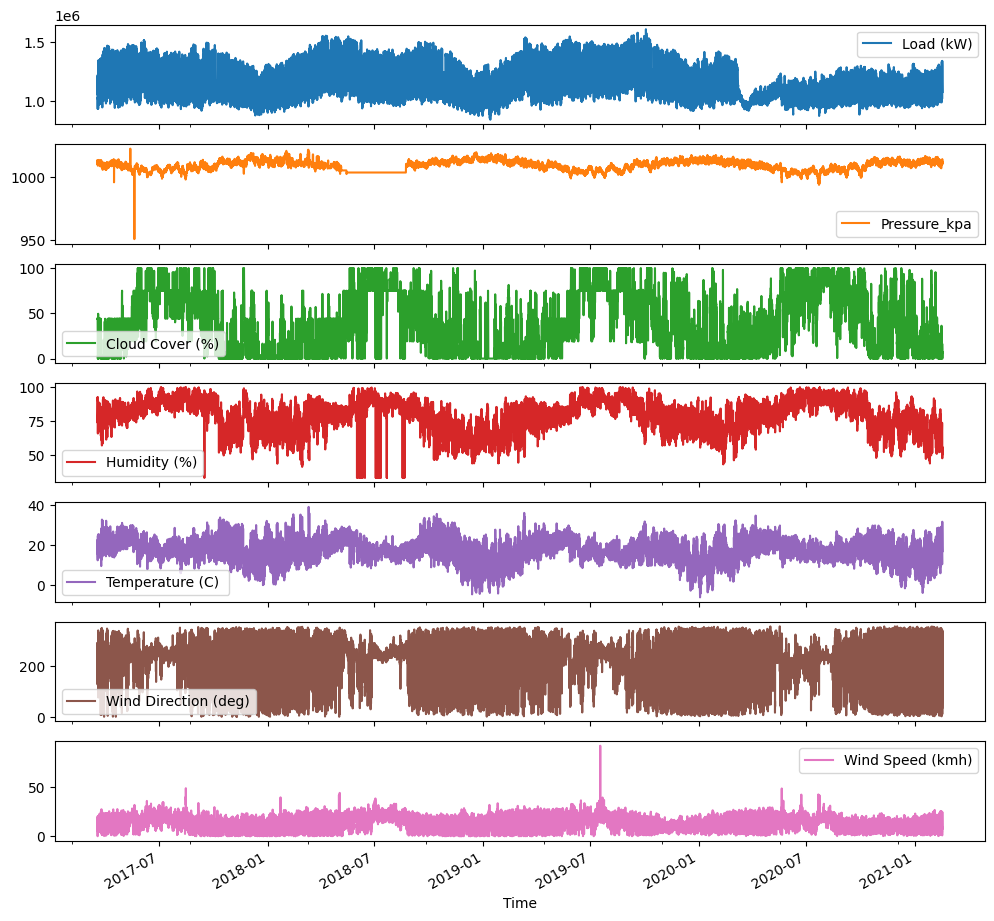

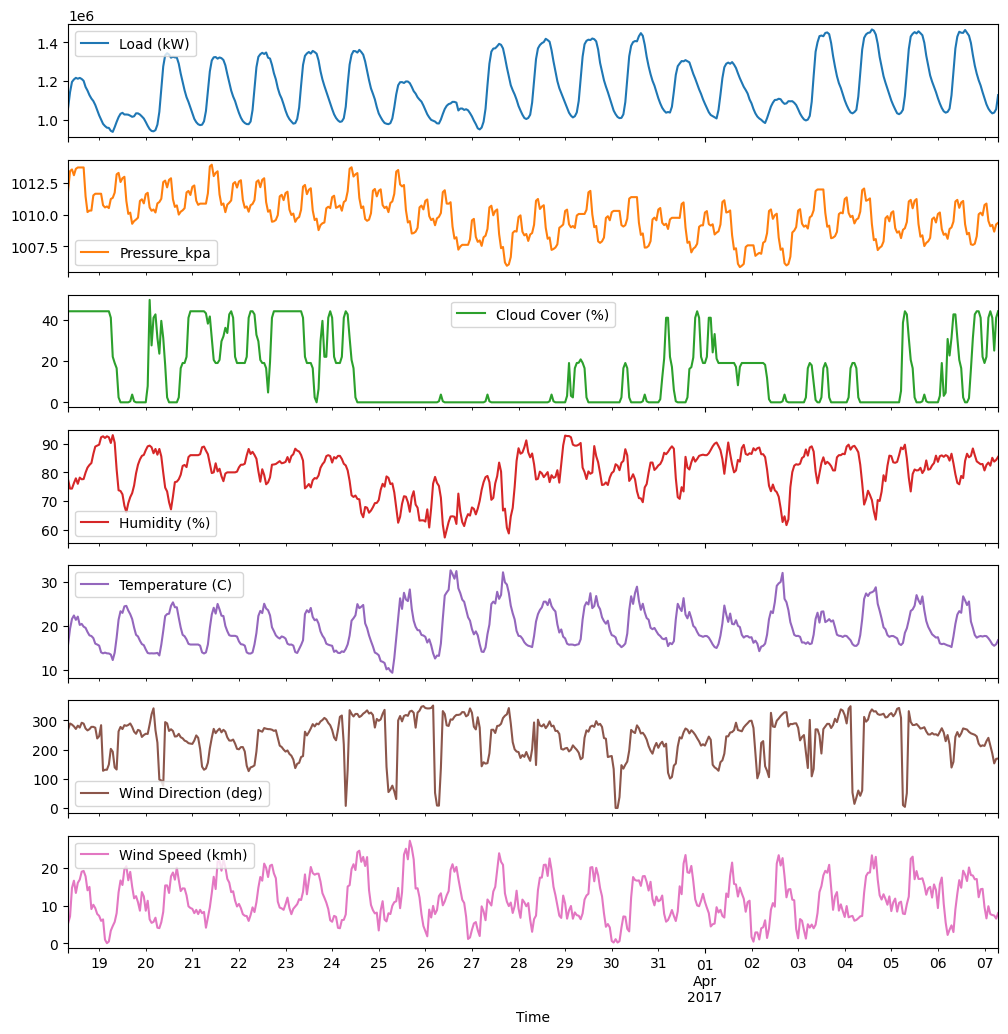

In [7]:
print(df.shape)
df.head()

plot_cols = ['Load (kW)', 'Pressure_kpa', 'Cloud Cover (%)', 'Humidity (%)',
       'Temperature (C) ', 'Wind Direction (deg)', 'Wind Speed (kmh)']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(12, 12))

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, figsize=(12, 12))

Dataset statistics:

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Load (kW),34360.0,1148486.793862,148320.957261,845471.358137,1029711.339137,1112138.956637,1249680.429287,1605192.043137
Pressure_kpa,34360.0,1009.425391,3.97407,950.595,1006.35,1009.925,1012.4,1022.915
Cloud Cover (%),34360.0,39.815308,32.364608,0.0,8.0,40.875,74.5,100.0
Humidity (%),34360.0,79.580244,11.339111,33.333333,72.0,81.41667,88.666667,100.0
Temperature (C),34360.0,16.73184,5.774698,-6.418114,13.431889,16.681886,20.531886,39.066886
Wind Direction (deg),34360.0,209.447028,94.733169,0.0,125.75,239.125,285.625,357.5
Wind Speed (kmh),34360.0,12.689488,6.640257,0.0,7.64625,11.9425,17.714063,91.4975
Load (kW)_trend,34360.0,1175041.976009,78017.634206,958987.864735,1114385.802114,1183657.834617,1233018.766407,1362826.576035
Load (kW)_seasonal,34360.0,24.418787,134205.768383,-244014.553155,-120921.772376,-429.270931,130749.180642,249756.716723
Load (kW)_resid,34360.0,-26579.600934,67817.314594,-397166.707035,-11164.556048,-1469.991233,2382.044568,234391.073451


## Feature engineering

Wind direction degrees:

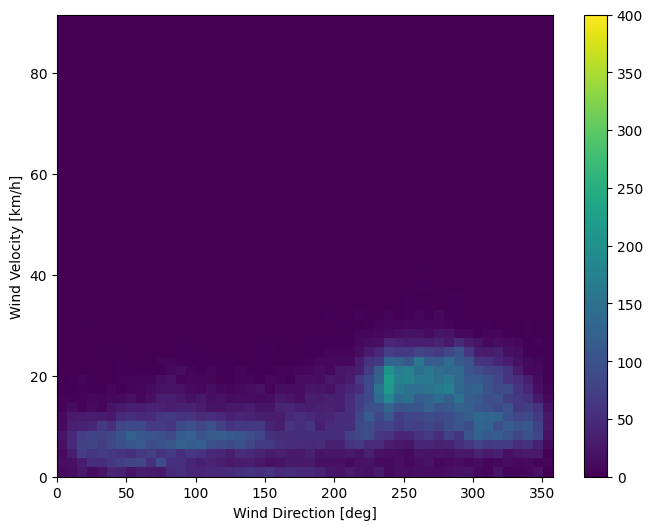

In [9]:
ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wind Direction (deg)'], df['Wind Speed (kmh)'],
           bins=(50, 50),
           vmax=400, # linear normalization
)
plt.colorbar()

plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [km/h]')
plt.savefig("pics/wind_direction_velocity.svg")
plt.savefig("pics/wind_direction_velocity.png")

Wind direction degrees to wind vector:

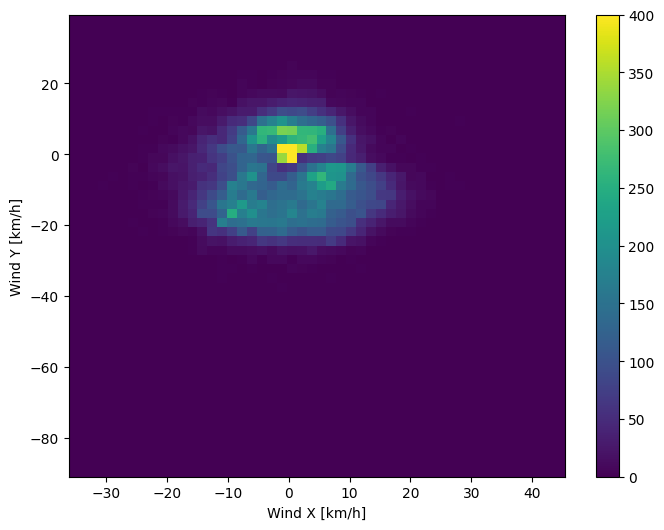

In [10]:
wv = df.pop('Wind Speed (kmh)')
# Convert to radians.
wd_rad = df.pop('Wind Direction (deg)') * np.pi / 180.0
# Calculate the wind x and y components.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wx'], df['Wy'],
              bins=(50, 50),
           vmax=400 # linear normalization
           )
plt.colorbar()
plt.xlabel('Wind X [km/h]')
plt.ylabel('Wind Y [km/h]')

plt.savefig("pics/wind_vectors.svg")
plt.savefig("pics/wind_vectors.png")

Time:

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
if do_DecompositionResiduals and do_extras:
    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

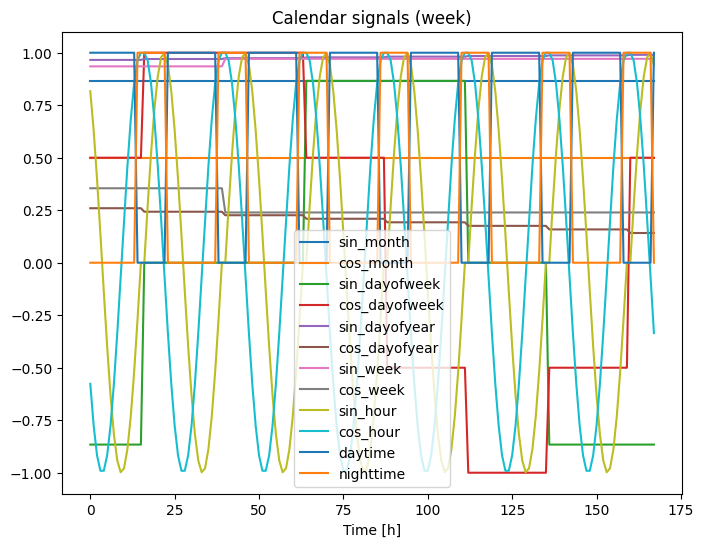

In [13]:
if do_DecompositionResiduals:
    plot_range = 24 * 7

    legend = []
    for column in df.columns:
        if "cos" in column or "sin" in column or "time" in column:
            plt.plot(np.array(df[column])[:plot_range])
            legend.append(column)
    plt.legend(legend)
    plt.xlabel('Time [h]')
    plt.title('Calendar signals (week)')
    plt.savefig("pics/calendar_DR.svg")
    plt.savefig("pics/calendar_DR.png")
    plt.savefig("pics/calendar_DR.pdf")

In [14]:
if do_DecompositionResiduals and do_extras:
    fft = tf.signal.rfft(df['Load (kW)'])
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = len(df['Load (kW)'])
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset
    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 2.5 * 1e9)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 7, 30, 365.2524/4.0, 365.2524], labels=['1/Year', '1/Quarter-year', '1/month', '1/week', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')

Weekly lag:

In [15]:
df['Load (kW)_lag7d'] = df['Load (kW)'].shift(24*7).bfill()
df['Load (kW)_lag6d'] = df['Load (kW)'].shift(24*6).bfill()
df['Load (kW)_lag5d'] = df['Load (kW)'].shift(24*5).bfill()

Convert to float32:

In [16]:
df = df.astype(np.float32)

Do split the data:

In [17]:
train_df = df[0:int(n*train_ratio)]
val_df = df[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]
test_df = df[int(n*(train_ratio + validation_ratio)):]

num_features = df.shape[1]

# Plot time periods:
print("Train (", train_df.shape[0], "):\n\t", train_df.head(1).index.values, " to ", train_df.tail(1).index.values)
print("Validation (", val_df.shape[0], "):\n\t", val_df.head(1).index.values, " to ", val_df.tail(1).index.values)
print("Test (", test_df.shape[0], "):\n\t", test_df.head(1).index.values, " to ", test_df.tail(1).index.values)

Train ( 24052 ):
	 ['2017-03-18T08:00:00.000000000']  to  ['2019-12-15T11:00:00.000000000']
Validation ( 6871 ):
	 ['2019-12-15T12:00:00.000000000']  to  ['2020-09-26T18:00:00.000000000']
Test ( 3437 ):
	 ['2020-09-26T19:00:00.000000000']  to  ['2021-02-16T23:00:00.090000000']


Normalize the data:

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Feature distributions:

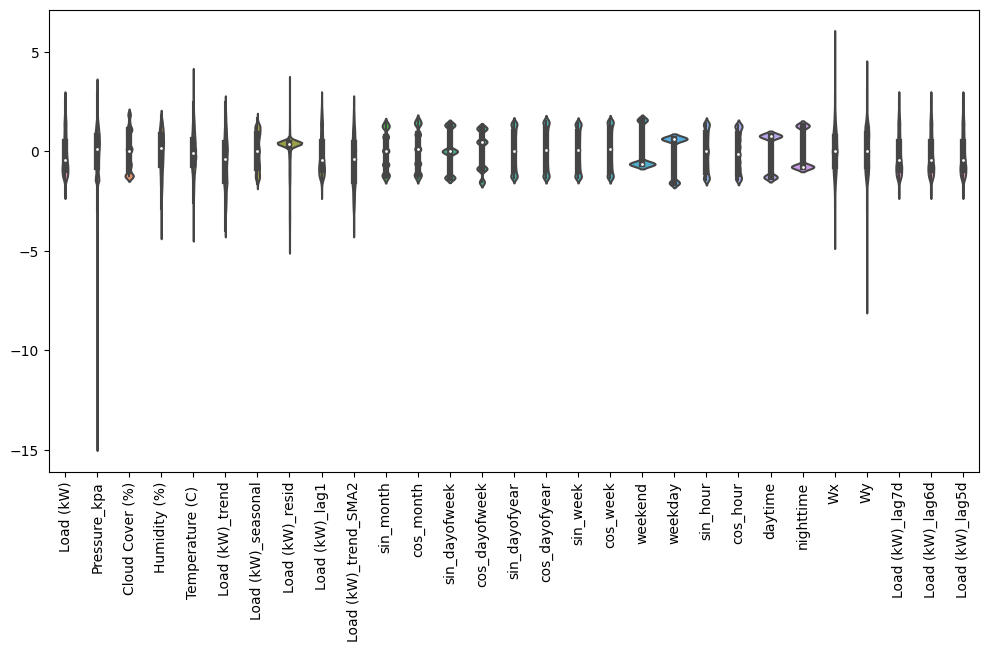

In [19]:
df_std = (df - train_mean) / train_std
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Nonlinear Model

Parameters:

In [20]:
torch.manual_seed(seed) # Set random seed for reproducibility

# Define hyperparameters
input_size = train_df.shape[1] # Number of features
hidden_size = 64
output_size = 24
batch_size = 32
learning_rate = 0.001
num_epochs = 20

Methods:

In [21]:
def get_data_IO_tensors(input_df):
    data_time_series = input_df.to_numpy()
    print(data_time_series.shape)

    seq_length = 24
    padding = 1
    index_start = seq_length
    index_end = data_time_series.shape[0] - seq_length 
    # print(index_start, index_end)

    ls_input_data_window = []
    ls_output_data_window = []

    for i in range(index_start, index_end + 1, padding):
        index_Xs = np.arange(i - seq_length, i)
        index_ys = np.arange(i, i + seq_length)
        Xs = data_time_series[index_Xs, :]
        ys = data_time_series[index_ys, 0]
        # print(index_Xs, "->", index_ys, Xs.shape, ys.shape)
        # print("Xs", Xs)
        # print("ys", ys)  
        ls_input_data_window.append(Xs)
        ls_output_data_window.append(ys)

    input_data_window = torch.tensor(ls_input_data_window).float()
    # print(input_data_window.shape)
    output_data_window = torch.tensor(ls_output_data_window).float()
    # print(output_data_window.shape)

    return input_data_window, output_data_window

Peek into data:

In [22]:
train_df.head(24 * 7)

,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Load (kW)_trend,Load (kW)_seasonal,Load (kW)_resid,Load (kW)_lag1,Load (kW)_trend_SMA2,...,weekday,sin_hour,cos_hour,daytime,nighttime,Wx,Wy,Load (kW)_lag7d,Load (kW)_lag6d,Load (kW)_lag5d
Time,,,,,,,,,,,,,,,,,,,,,
2017-03-18 08:00:00,-0.749230,0.615218,0.124404,-0.202101,-0.258401,-1.824837,-0.205763,0.372956,-0.749236,-1.824717,...,-1.577891,1.180110,-0.857990,0.774478,-0.774477,-0.010436,0.133491,-0.74758,-0.747443,-0.748113
2017-03-18 09:00:00,-0.227298,1.002543,0.124404,-0.477572,0.376508,-1.824465,0.339062,0.381169,-0.749236,-1.824717,...,-1.577891,0.911577,-1.134220,0.774478,-0.774477,0.312383,-0.002010,-0.74758,-0.747443,-0.748113
2017-03-18 10:00:00,0.117642,1.035215,0.124404,-0.477572,0.775849,-1.824092,0.705380,0.374174,-0.227302,-1.824345,...,-1.577891,0.575428,-1.330604,0.774478,-0.774477,0.517524,-0.697901,-0.74758,-0.747443,-0.748113
2017-03-18 11:00:00,0.200960,0.921185,0.124404,-0.306333,0.918087,-1.823724,0.794793,0.370417,0.117639,-1.823974,...,-1.577891,0.196593,-1.432577,0.774478,-0.774477,0.356326,-0.906155,-0.74758,-0.747443,-0.748113
2017-03-18 12:00:00,0.253979,1.047471,0.124404,-0.157431,0.739505,-1.823357,0.846082,0.378972,0.200958,-1.823606,...,-1.577891,-0.196831,-1.432577,0.774478,-0.774477,0.031218,-0.621582,-0.74758,-0.747443,-0.748113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-25 03:00:00,-1.254709,0.274676,-1.252958,-0.418011,-1.027919,-0.586413,-1.248032,0.346717,-1.172093,-0.583389,...,-1.577891,1.055678,0.889667,-1.291139,1.291139,0.746215,0.388949,-0.74758,-1.355227,-1.521095
2017-03-25 04:00:00,-1.280575,0.302639,-1.252958,-0.097869,-1.287267,-0.592193,-1.288162,0.376992,-1.254716,-0.589322,...,-1.577891,1.282558,0.580882,-1.291139,1.291139,-0.568074,0.968259,-0.74758,-1.409985,-1.532563
2017-03-25 05:00:00,-1.293664,0.193947,-1.252958,-0.142540,-1.232974,-0.597305,-1.292644,0.362942,-1.280583,-0.594769,...,-1.577891,1.414307,0.224741,-1.291139,1.291139,0.602236,1.232414,-0.74758,-1.418361,-1.492340


### Model training:

Models:

In [23]:
# Define the LSTMForecast model
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMForecast, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output of the last time step only
        return out

# Define the GRUForecast model
class GRUForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUForecast, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Taking the output of the last time step only
        return out

# Define a 1D convolutional CNN model        
class CNN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
        )
    def forward(self, x):
        out = self.cnn(x.transpose(1, 2))
        out = out.transpose(1, 2)
        return out[:, -1, :]

# Define an LSTM with attention model
class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        attention_weights = self.attention(out).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        out = torch.sum(out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(out)
        return out

# Define a Temporal Convolutional Network (TCN) model
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dilation=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dilation=2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dilation=3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dilation=3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dilation=3),
        )
    def forward(self, x):
        out = self.tcn(x.transpose(1, 2))
        out = out.transpose(1, 2)
        return out[:, -1, :]

Dataframes to pytorch tensors (Time series to windows IN (24 x variables) -> OUT (24 x 1).transpose):

In [24]:
train_input_data_window, train_output_data_window = get_data_IO_tensors(train_df)
print("Training:", train_input_data_window.shape, train_output_data_window.shape)

val_input_data_window, val_output_data_window = get_data_IO_tensors(val_df)
print("Validation:", val_input_data_window.shape, val_output_data_window.shape)

test_input_data_window, test_output_data_window = get_data_IO_tensors(test_df)
print("Testing:", test_input_data_window.shape, test_output_data_window.shape)

(24052, 29)
Training: torch.Size([24005, 24, 29]) torch.Size([24005, 24])
(6871, 29)
Validation: torch.Size([6824, 24, 29]) torch.Size([6824, 24])
(3437, 29)
Testing: torch.Size([3390, 24, 29]) torch.Size([3390, 24])


Data preperation:

In [25]:
# Create DataLoader objects for training and validation
train_dataset = TensorDataset(train_input_data_window, train_output_data_window)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = TensorDataset(val_input_data_window, val_output_data_window)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Model training:

In [26]:
# Create an instance of the DNN model - Choose one of the models defined below

model = LSTMForecast(input_size, hidden_size, output_size)
# model = GRUForecast(input_size, hidden_size, output_size)
# model = CNN(input_size, output_size, hidden_size, kernel_size=3, dropout=0.1)
# model = TCN(input_size, output_size, hidden_size, kernel_size=3, dropout=0.1)  # TODO: fix
# model = LSTMAttention(input_size, hidden_size, output_size)
# TODO: add FCN, FC, WaveletLSTM, FFTLSTM, UMAPLSTM, TensorDecompositionLSTM, etc.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # inputs = inputs.to(device)
        # targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(validation_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.1451, Validation Loss: 0.2043
Epoch 2/20, Train Loss: 0.0575, Validation Loss: 0.1679
Epoch 3/20, Train Loss: 0.0485, Validation Loss: 0.1555
Epoch 4/20, Train Loss: 0.0449, Validation Loss: 0.1531
Epoch 5/20, Train Loss: 0.0430, Validation Loss: 0.1442
Epoch 6/20, Train Loss: 0.0416, Validation Loss: 0.1432
Epoch 7/20, Train Loss: 0.0405, Validation Loss: 0.1388
Epoch 8/20, Train Loss: 0.0397, Validation Loss: 0.1390
Epoch 9/20, Train Loss: 0.0390, Validation Loss: 0.1323
Epoch 10/20, Train Loss: 0.0384, Validation Loss: 0.1399
Epoch 11/20, Train Loss: 0.0376, Validation Loss: 0.1296
Epoch 12/20, Train Loss: 0.0368, Validation Loss: 0.1309
Epoch 13/20, Train Loss: 0.0368, Validation Loss: 0.1322
Epoch 14/20, Train Loss: 0.0359, Validation Loss: 0.1268
Epoch 15/20, Train Loss: 0.0349, Validation Loss: 0.1255
Epoch 16/20, Train Loss: 0.0345, Validation Loss: 0.1268
Epoch 17/20, Train Loss: 0.0341, Validation Loss: 0.1352
Epoch 18/20, Train Loss: 0.0334, Validat

### Results:

All test data accuracy (post-sample):

In [27]:
l1losses = []
l2losses = []
for index in range(0, test_input_data_window.shape[0]):
    outputs = model(test_input_data_window[index, :, :].unsqueeze(0))
    l1loss =  nn.L1Loss()(outputs, test_output_data_window[index].unsqueeze(0))
    l1losses.append(l1loss.detach().numpy())
    l2loss =  nn.MSELoss()(outputs, test_output_data_window[index].unsqueeze(0))
    l2losses.append(l2loss.detach().numpy())
print(f"ALL test data - Model type: {'DR-DNN' if do_DecompositionResiduals else 'No DR'} {model.__class__.__name__}\n\t -> l1 loss: {np.array(l1losses).mean():.2f} +/- {np.array(l1losses).std():.2f}, MSE: {np.array(l2losses).mean():.2f} +/- {np.array(l2losses).std():.2f}")    

ALL test data - Model type: DR-DNN LSTMForecast
	 -> l1 loss: 0.16 +/- 0.09, MSE: 0.04 +/- 0.06


Some random test data predictions visually:

In [34]:
np.random.seed(seed)

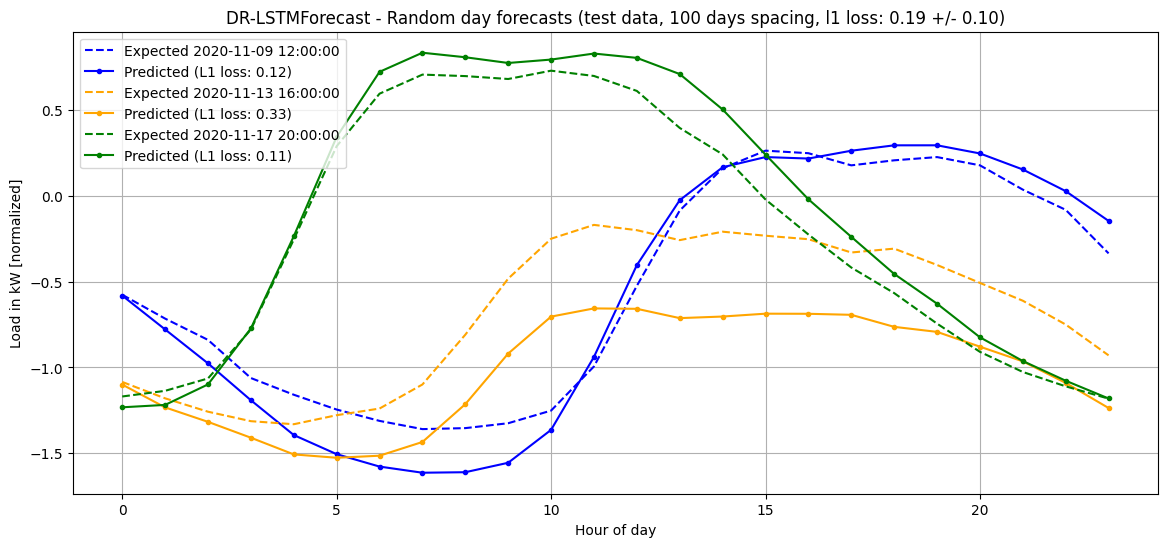

In [41]:
max_sample = 300
offset = np.random.randint(0, test_input_data_window.shape[0] - max_sample)
color = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
color_index = 0
plt.figure(figsize=(14, 6))
l1losses = []
step_size = 100
for index in range(offset, offset + max_sample, step_size):
    outputs = model(test_input_data_window[index, :, :].unsqueeze(0))
    l1loss =  nn.L1Loss()(outputs, test_output_data_window[index].unsqueeze(0))
    l1losses.append(l1loss.detach().numpy())
    date =  pd.to_timedelta(16, unit='h') + test_df.index[index]
    plt.plot(test_output_data_window[index].detach().numpy().flatten(), "--", color=color[color_index], label=f"Expected {date}")
    plt.plot(outputs.detach().numpy().flatten(), ".-", color=color[color_index], label=f"Predicted (L1 loss: {l1loss:.2f})")    
    plt.legend()
    color_index += 1
plt.title(f"{'DR-' if do_DecompositionResiduals else ' No DR'}{model.__class__.__name__} - Random day forecasts (test data, 100 days spacing, l1 loss: {np.array(l1losses).mean():.2f} +/- {np.array(l1losses).std():.2f})")
plt.xlabel("Hour of day")
plt.ylabel("Load in kW [normalized]")
plt.grid()    
plt.show()